# Ahead of time flood prediction using LSTM



In [0]:
#Flood Early Warning System using IoT and Edge 

#Eric Samikwa

In [2]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math


from keras.models import Sequential
from keras.layers import Dense     
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')


Using TensorFlow backend.


# Data pre-processing

In [0]:
# fix random seed for reproducibility of results
np.random.seed(10)

### Hourly rainfall data

In [0]:
df_rain = pandas.read_csv("/content/hourly_rainfall_train.csv")

In [5]:
#display first 5
df_rain.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm)
0,2018-12-02 18:00:00,0.0,0.0
1,2018-12-02 17:00:00,0.0,0.0
2,2018-12-02 16:00:00,0.0,0.0
3,2018-12-02 15:00:00,0.0,0.0
4,2018-12-02 14:00:00,0.0,0.0


In [6]:
#dataframe shape
df_rain.shape

(78848, 3)

In [7]:
#dataset properties
df_rain.describe()  


,Current rainfall (mm),Cumulative rainfall (mm)
count,78844.000000,78847.000000
mean,0.049206,0.586580
std,0.765296,2.770216
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,110.000000,111.400000


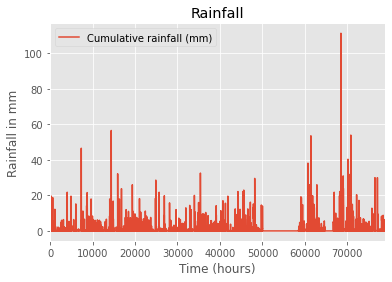

In [8]:
df_rain.plot( y='Cumulative rainfall (mm)')  

plt.title('Rainfall')  
plt.xlabel('Time (hours)')  
plt.ylabel('Rainfall in mm')  
plt.show()  

### Hourly water level data

In [0]:
df_water_level = pandas.read_csv("/content/hourly_water_level_train.csv")

In [10]:
df_water_level.head()

,Date/Time,Level (m)
0,2018-12-02 17:00:00,1.61
1,2018-12-02 16:00:00,1.61
2,2018-12-02 15:00:00,1.62
3,2018-12-02 14:00:00,1.63
4,2018-12-02 13:00:00,1.63


In [11]:
df_water_level.shape

(78822, 2)

In [12]:
#dataset properties
df_water_level.describe()

,Level (m)
count,78822.000000
mean,1.453701
std,0.113859
min,0.000000
25%,1.400000
50%,1.450000
75%,1.500000
max,3.300000


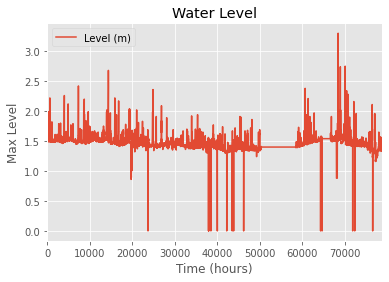

In [13]:
df_water_level.plot(y='Level (m)')  
plt.title('Water Level')  
plt.xlabel('Time (hours)')  
plt.ylabel('Max Level')  
plt.show() 

### Combining dataset

In [14]:
#dataset merged on date_time 
dataset = pandas.merge(df_rain, df_water_level, how='outer', on=['Date/Time'])
dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,NaN
1,2018-12-02 17:00:00,0.0,0.0,1.61
2,2018-12-02 16:00:00,0.0,0.0,1.61
3,2018-12-02 15:00:00,0.0,0.0,1.62
4,2018-12-02 14:00:00,0.0,0.0,1.63


### Filling missing values

In [15]:
#filling all missing values with mean of the column
dataset['Cumulative rainfall (mm)'] = dataset['Cumulative rainfall (mm)'].fillna(dataset['Cumulative rainfall (mm)'].mean())
dataset['Level (m)'] = dataset['Level (m)'].fillna(dataset['Level (m)'].mean())

dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,1.453701
1,2018-12-02 17:00:00,0.0,0.0,1.610000
2,2018-12-02 16:00:00,0.0,0.0,1.610000
3,2018-12-02 15:00:00,0.0,0.0,1.620000
4,2018-12-02 14:00:00,0.0,0.0,1.630000


### Removing unwanted columns

In [16]:
dataset = dataset.drop(columns=['Current rainfall (mm)', 'Date/Time','Cumulative rainfall (mm)'])
dataset.shape

(78850, 1)

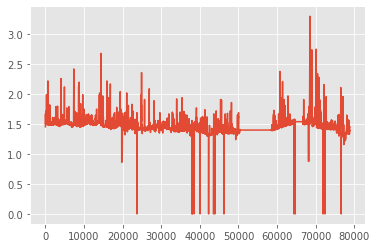

In [17]:
plt.plot(dataset)

### Scaling dataset 

In [0]:
# normalize the dataset (LSTMs are sensitive to the scale of the input data)
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Spliting dataset (train & test)

In [19]:
# split into train and test sets
train_size  = int(len(dataset) * 0.7)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

55195 23655


----------------- TRAINING DATA -----------------


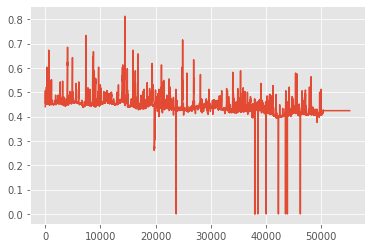

----------------- TEST DATA -----------------


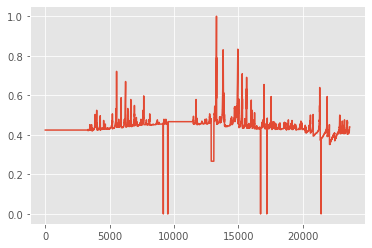

In [20]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

# Training 

### Dataset sliding window 

In [0]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
# n-10 sliding window equivalent to 10 hours of historical data
# the predicted out y is 10 hours ahead of time
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model (LSTM)

In [24]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4,activation='relu',recurrent_activation='relu',use_bias=True,dropout=0.1, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="relu", recurrent_activation="relu", use_bias=True, dropout=0.1, input_shape=(None, 10))`
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


## Model Learning

In [26]:
#training : 4 epochs and batch size 1
history = model.fit(trainX, trainY, nb_epoch=4, batch_size=1, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.





Epoch 1/4





 - 92s - loss: 0.0010
Epoch 2/4
 - 91s - loss: 5.8367e-04
Epoch 3/4
 - 91s - loss: 5.3332e-04
Epoch 4/4
 - 91s - loss: 3.9501e-04


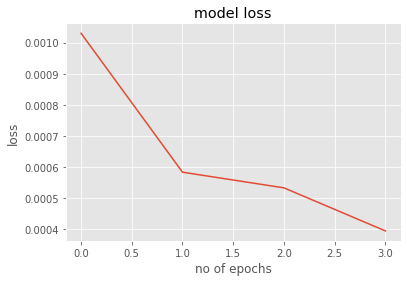

In [27]:
# Plot training
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no of epochs')
plt.show()

## Model Evaluation

In [28]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
#trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
#testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


# Testing

### Predictions

In [0]:
#predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

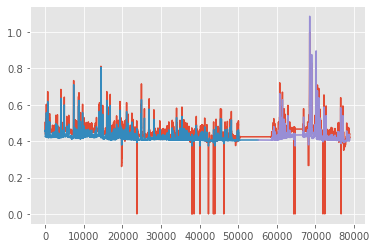

In [34]:
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict)+slide_window, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

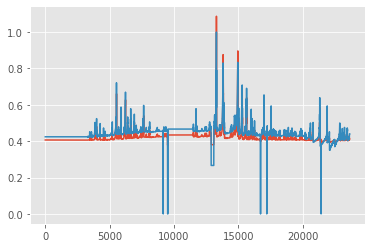

In [35]:
plt.plot(testPredict)
plt.plot(testY)

### Unseen data

In [0]:
# Test the network on an unseen data
unseen = pandas.read_csv('/content/flood_pred_test.csv',sep=',')

In [0]:
unseen.head()

In [0]:
unseen_test = unseen['Level (m)'].values

In [0]:
plt.plot(unseen_test[0:20000])

In [0]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

In [0]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [0]:
unseen_results = model.predict(features)

In [0]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results)
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels)
plt.show()

### Test scores

In [0]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

In [0]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(unseen_results[0:20000])
plt.show()

print('----------------- Ground Truth ---------------')
plt.plot(labels[0:20000])
plt.show()